# Statistics tutorial 1
## Covering resampling, AB testing and p-values

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

suppose we have data as follows:

|clicks|headline A | headline B|total|
|:------|:------:|:-----:|:--------:|
| yes  |  31  |  21  | 52    |
| no   | 169  | 179 | 348    |
|total | 200  | 200 |  400   |


we want to figure out whether headline A is better than headline B by a statistically significant margin.
the way we can do that is by doing a simple **A/B test**.

the test will be done in the following steps:
* **resampling**
* drawing a histogram and the observation for visual comparison
* computation of the **p-value**

steps will be explained as we progress

In [4]:
totno=np.zeros(348)   #generate 348 0's equaling total number of no's 
totyes=np.ones(52)    #generate 52 1's equaling total number of yes's
tot=np.append(totyes,totno)      #put them all in the same array
tot.shape                        #print length of the array (=400 = total number of measurements)

(400,)

In [6]:
expy=52/400   #expected number of yes's in the total population
expn=348/400  #expected number of no's in the total population

In [7]:
expy

0.13

In [8]:
obsdiff=((31*1+169*0)/200)-(21*1+179*0)/200 #difference of means of headline A and headline B

Null hypothesis states that the headlines A and B are equally efficient.
To test the hypothesis we create a new population equal to the combined population of observations A and B.
This total population has 348 zeros and 5 ones.

We now do **resampling** procedure! We reshuffle ones and zeros in tot, and we put first 200 components of tot in "fake A" group and last 200 components in "fake B" group. We compute the average of each. We take difference of the averages and we save it. This is repeated many times!

In [13]:
diff=np.array([])  # we save differences of sample means here
for i in range(2000):
    np.random.shuffle(tot) #this reshuffles components of tot
    fakeA=np.sum(tot[:200]==1)/200
    fakeB=np.sum(tot[200:]==1)/200
    diff=np.append(diff,fakeA-fakeB)

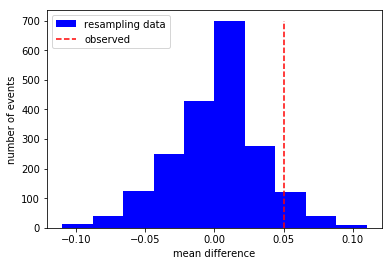

In [30]:
plt.hist(diff,color='b',label='resampling data')
plt.vlines(obsdiff,0,700,colors='r',linestyles='dashed',label='observed')
plt.legend(loc='upper left')
plt.xlabel("mean difference")
plt.ylabel("number of events")
plt.show()

it is clear from visual inspection that random resampling often generates mean differences larger than the one observed. let us now get the p-value.

we compute p-value as the percentage of events larger than the observed mean difference.

In [35]:
#number of events larger than the observed event is:
np.sum((diff>obsdiff)==1)

85

we can use analogous commands to check that there are 1143 events larger than 0 and 857 event smaller than zero.

we know that we've generated 2000 resamplings, so the percantage of them that are larger than the observed difference is:

In [38]:
85/2000

0.0425

this is our p-value, it equals 4.25%

had we chosen initially that **p-value has to be lower than 5%** if the null hypothesis is to be falsified, we would have to conclude that it is in fact falsified, and thus headline A is (statistically) significantly better than headline B. 

had we chosen **alpha equal to 1%** instead of 5% (where alpha is a common name for the threshold on p-value) then we would have to conclude that the two headlines are equally good, i.e. there is no statistically significant difference.

let us see what happens if we increase the number of resamplings.

In [39]:
diff=np.array([])  # we save differences of sample means here
for i in range(10000):
    np.random.shuffle(tot) #this reshuffles components of tot
    fakeA=np.sum(tot[:200]==1)/200
    fakeB=np.sum(tot[200:]==1)/200
    diff=np.append(diff,fakeA-fakeB)

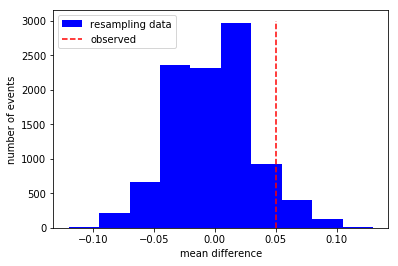

In [41]:
plt.hist(diff,color='b',label='resampling data')
plt.vlines(obsdiff,0,3000,colors='r',linestyles='dashed',label='observed')
plt.legend(loc='upper left')
plt.xlabel("mean difference")
plt.ylabel("number of events")
plt.show()

In [42]:
#number of events larger than the observed event is:
np.sum((diff>obsdiff)==1)

541

In [43]:
514/10000

0.0514

this time we got p-value of 5.14%
this is more trustworthy than the original analysis because number of resamplings is greater.
in addition, this result shows that we were running high risk of commiting **type-I error**, namely concluding the existence of a statistically significant effect when there is none (**false positive**)

let us repeat resampling one more time to confirm convergence towards the "correct result":

In [49]:
diff=np.array([])  # we save differences of sample means here
for i in range(20000):
    np.random.shuffle(tot) #this reshuffles components of tot
    fakeA=np.sum(tot[:200]==1)/200
    fakeB=np.sum(tot[200:]==1)/200
    diff=np.append(diff,fakeA-fakeB)
print("p-value is: "+str(np.sum((diff>obsdiff)==1)/20000*100)+"%")

p-value is: 5.18%


PS. note that the p-value still varies a lot based on the random reshuffling. e.g. running the above line multiple time I got p-values anywhere between 4.7% and 5.2%

now we can try to do the standard t-test contained in scipy.stats as ttest_ind

the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) says:

*Calculate the T-test for the means of two independent samples of scores.*

*This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.*

In [54]:
#we need to have data in array form
arrayA=np.zeros([200])
arrayA[:31]=1
arrayB=np.zeros([200])
arrayB[:21]=1
#insert data in the t-test
stats.ttest_ind(arrayA,arrayB)

Ttest_indResult(statistic=1.4871457824809056, pvalue=0.13776809124736633)

Here *statistic* stands for the calculated t-statistic and *pvalue* stands for the **two-tailed** p-value.
Note that we've computed **one-tailed** p-value above. The difference is whether you're interested in the probability of obtaining mean difference as extreme as yours only on one side or on both sides of the histograms that we plotted above. We only cared about the right hand side, so we should perform a one-sided t-test.

scipy doesn't support this but for a symmetric distribution there is a relation between the two p-values: one-sided is 1/2 of the two-sided. one should be careful while doing this as the p-values should be considered in combination with the sign of the t-statistic, see [this](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/) for clarification.

in our case t-statistic is positive and we're asking the probability of having a value larger than that. what we computed is prob(>statistic)+prob(<(-statistic)), and since t-distribution is symmetric this is simply 2xprob(>statistic), so one-sided p-value is simply one half of the reported value, which is:

In [55]:
.13777/2

0.068885

which corresponds to p-value of: 6.89%
and thus the null hypothesis should be kept (i.e. it cannot be rejected).